In [7]:
import tal
import os

# TODO: if you want to follow this tutorial,
# you need to have rendered the scene using the "tal render nlos-z" shell command
# See README.md for more information
# Write here   vvvvvvvvvvvvv   the path to your rendered scene
data=[]
root = './n-los/10m'

data = tal.io.read_capture(os.path.join(root, 'n-los.hdf5'))

RuntimeError: ​[xml.cpp:1079] Error while loading "/home/jsolan/mitransient_SPAD/SPAD/examples/tal/n-los/10m/nlos_scene.xml" (near line 3, col 6): could not instantiate integrator plugin of type "transient_nlos_path": 
[xml.cpp:1079]   [PluginManager] Plugin "transient_nlos_path" not found!

In [3]:
# because this is a test scene, we know the hidden geometry
# is located at Z = 1
# this volume_xyz is coplanar to the relay wall (rw) at Z=1
volume_xyz = tal.reconstruct.get_volume_project_rw(data, depths=[1.0,])

In [5]:
print(scene.sensors()[0].sampler().sample_count())

NameError: name 'scene' is not defined

In [9]:
import matplotlib.pyplot as plt
from tal.io.capture_data import NLOSCaptureData
import numpy as np
import scipy.stats as stats


def plot_amplitude(image: np.ndarray, result, samples, CTP, title: str = ''):
    vector = image.squeeze().T
    
    result = np.copy(vector)
    for i in range(1, vector.shape[0] - 1):
        for j in range(1, vector.shape[1] - 1):
            aux = 0
            modifiers = [stats.binom.rvs(samples, CTP) / samples for _ in range(8)]

            aux = (vector[i+1,j] * modifiers[0])
            aux += (vector[i-1,j] * modifiers[1])
            aux += (vector[i,j+1] * modifiers[2])
            aux += (vector[i,j-1] * modifiers[3])
            aux += (vector[i+1, j+1] * modifiers[4])
            aux += (vector[i-1, j-1] * modifiers[5])
            aux += (vector[i-1, j+1] * modifiers[6])
            aux += (vector[i+1, j-1] * modifiers[7])

            result[i, j] = vector[i, j] - (vector[i, j] * sum(modifiers)) + aux

    
    # Configurar la figura y el eje
    fig, ax = plt.subplots(figsize=(6, 5))
    
    mappable = ax.imshow(np.abs(result), cmap='afmhot')
    
    # Añadir barra de color
    fig.colorbar(mappable, ax=ax)
    
    # Configurar etiquetas y título
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # Mostrar la imagen
    plt.show()

tal.reconstruct.filter_H: Using wavelengths from 0.0399m to 0.1288m


tal.reconstruct.filter_H (pf, 3/3): 100%|██████████| 3/3 [00:00<00:00, 12.61it/s]


tal.reconstruct.utils: Assuming that volume_xyz is X_Y_Z_3
tal.reconstruct.filter_H: Using wavelengths from 0.0399m to 0.1288m
tal.reconstruct.utils: Assuming that volume_xyz is X_Y_Z_3


tal.reconstruct.filter_H (pf, 3/3): 100%|██████████| 3/3 [00:00<00:00, 29.09it/s]


tal.reconstruct.filter_H: Using wavelengths from 0.0399m to 0.1288m
tal.reconstruct.utils: Assuming that volume_xyz is X_Y_Z_3


tal.reconstruct.filter_H (pf, 3/3): 100%|██████████| 3/3 [00:00<00:00, 29.06it/s]


tal.reconstruct.filter_H: Using wavelengths from 0.0399m to 0.1288m
tal.reconstruct.utils: Assuming that volume_xyz is X_Y_Z_3


tal.reconstruct.filter_H (pf, 3/3): 100%|██████████| 3/3 [00:00<00:00, 25.79it/s]


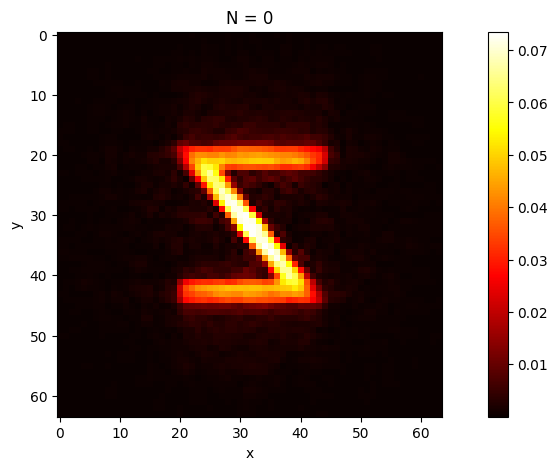

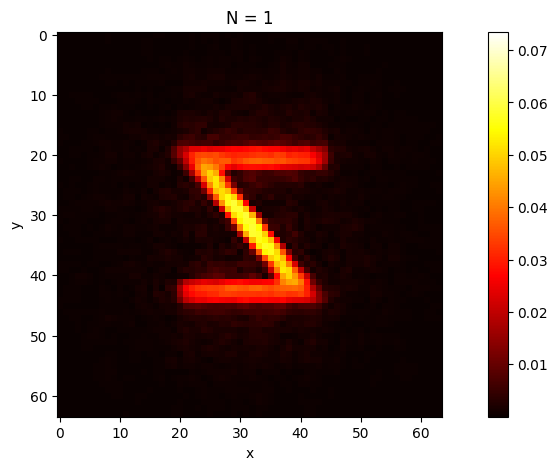

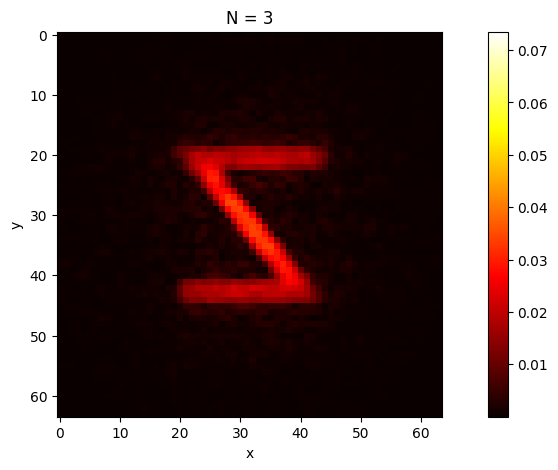

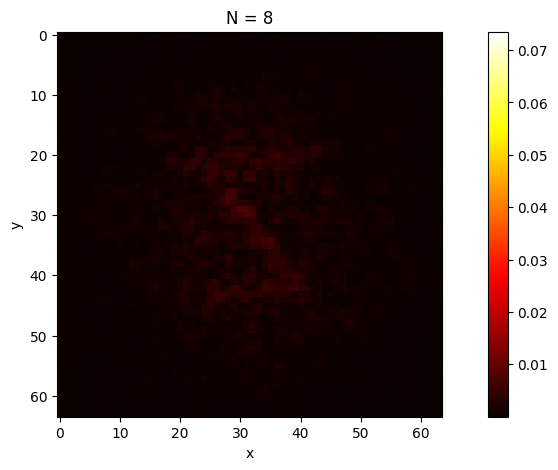

In [10]:

H_1 = tal.reconstruct.fbp.solve(data,
                                wl_mean=0.06, wl_sigma=0.06,
                                volume_xyz=volume_xyz, camera_system=tal.enums.CameraSystem.DIRECT_LIGHT)
plot_amplitude(H_1,"N = 0","1.png")